# Here We apply machine learning to predict mineral deposits(Basemetal) from Fault Proximity analysis 
* The Area is 45K degreesheet. It has rajpura-Dariba, Pur-Banera belts and rampura-Aguchha mine
* We have about 15 known mineral deposit locations(we assign them probability=1)
* For training purposes some of the deposits would be hidden from machine(but known to us). We hide Rampura-Aguchha and some from Pur-Banera(4 hidden)
* Therefore machine has to learn from 11 knwon deposits and predict the other 4
* For Machine Learning to work it has to know what is a deposit as well as what is not a deposit
* We randomly assume 10 points where we assign Probabilit=0 (This of course is an approximation. Ideally this should be done from deep(~upto 1-2 km at least) boreholes with no yield
* Now machine has about 11 deposits(P=1) and 10 non-deposits(P=0) from which our process starts starts

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from pyproj import Proj
from shapely.geometry import Point
from sklearn.neighbors import BallTree
myProj = Proj("+proj=utm +zone=43 +north +datum=WGS84 +units=m +no_defs")   # Define Projection to be UTM 43N.

In [2]:
df=pd.read_csv('45K_MPA.csv')
df.dropna(inplace=True)
df

,Unnamed: 0,index,UTM_X,UTM_Y,Lithology,Dist_from_fault,Probability_Mineralization
0,0,0,399300,2765350,GARNETIFEROUS MICA SCHIST,11493.289357,1
1,1,1,399350,2765350,GARNETIFEROUS MICA SCHIST,11444.307490,1
2,2,2,399400,2765350,GARNETIFEROUS MICA SCHIST,11395.334467,1
3,3,3,399450,2765350,GARNETIFEROUS MICA SCHIST,11346.370402,1
4,4,4,399500,2765350,GARNETIFEROUS MICA SCHIST,11297.415412,1
...,...,...,...,...,...,...,...
32549,32549,24594,449950,2845500,FINE AEOLIAN SAND AND SILT WITH OCCASSIONAL KA...,12117.647801,0
32550,32550,24595,450000,2845500,FINE AEOLIAN SAND AND SILT WITH OCCASSIONAL KA...,12076.174189,0
32551,32551,24596,450050,2845500,FINE AEOLIAN SAND AND SILT WITH OCCASSIONAL KA...,12034.765384,0
32552,32552,24597,450100,2845500,GARNETIFEROUS MICA SCHIST ? GRAPHITE,11993.422058,0


In [3]:
# Drop unnecesary index columns
df = df.drop(df.columns[[0, 1]], axis=1)
df

,UTM_X,UTM_Y,Lithology,Dist_from_fault,Probability_Mineralization
0,399300,2765350,GARNETIFEROUS MICA SCHIST,11493.289357,1
1,399350,2765350,GARNETIFEROUS MICA SCHIST,11444.307490,1
2,399400,2765350,GARNETIFEROUS MICA SCHIST,11395.334467,1
3,399450,2765350,GARNETIFEROUS MICA SCHIST,11346.370402,1
4,399500,2765350,GARNETIFEROUS MICA SCHIST,11297.415412,1
...,...,...,...,...,...
32549,449950,2845500,FINE AEOLIAN SAND AND SILT WITH OCCASSIONAL KA...,12117.647801,0
32550,450000,2845500,FINE AEOLIAN SAND AND SILT WITH OCCASSIONAL KA...,12076.174189,0
32551,450050,2845500,FINE AEOLIAN SAND AND SILT WITH OCCASSIONAL KA...,12034.765384,0
32552,450100,2845500,GARNETIFEROUS MICA SCHIST ? GRAPHITE,11993.422058,0


In [4]:
# let's ignore Lithology for now
df=df.drop(columns=['Lithology'])
df

,UTM_X,UTM_Y,Dist_from_fault,Probability_Mineralization
0,399300,2765350,11493.289357,1
1,399350,2765350,11444.307490,1
2,399400,2765350,11395.334467,1
3,399450,2765350,11346.370402,1
4,399500,2765350,11297.415412,1
...,...,...,...,...
32549,449950,2845500,12117.647801,0
32550,450000,2845500,12076.174189,0
32551,450050,2845500,12034.765384,0
32552,450100,2845500,11993.422058,0


In [5]:
# Inverse projection to get Long, Lat from UTM coordinates. Then we define WGS 1984(also called EPSG:4326) coordinate reference system(crs)
long,lat=myProj(df.UTM_X.values,df.UTM_Y.values, inverse=True)
geometry = [Point(xy) for xy in zip(long, lat)]                  # All locations converted to point geometry
df = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)        # Dataframe converted to Geospatial compatible dataframe(Geodataframe)
df

,UTM_X,UTM_Y,Dist_from_fault,Probability_Mineralization,geometry
0,399300,2765350,11493.289357,1,POINT (74.00211 25.00029)
1,399350,2765350,11444.307490,1,POINT (74.00260 25.00029)
2,399400,2765350,11395.334467,1,POINT (74.00310 25.00029)
3,399450,2765350,11346.370402,1,POINT (74.00359 25.00030)
4,399500,2765350,11297.415412,1,POINT (74.00409 25.00030)
...,...,...,...,...,...
32549,449950,2845500,12117.647801,0,POINT (74.50104 25.72658)
32550,450000,2845500,12076.174189,0,POINT (74.50154 25.72659)
32551,450050,2845500,12034.765384,0,POINT (74.50204 25.72659)
32552,450100,2845500,11993.422058,0,POINT (74.50254 25.72659)


<Axes: >

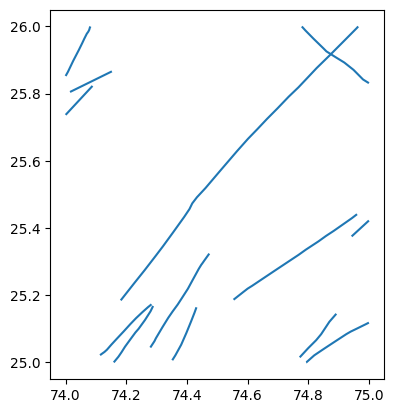

In [6]:
# Import fault shape file(for visualization only, distance already calculated earlier)
fault_shp=gpd.read_file('Fault Tectonic.shp')
fault_shp.plot()

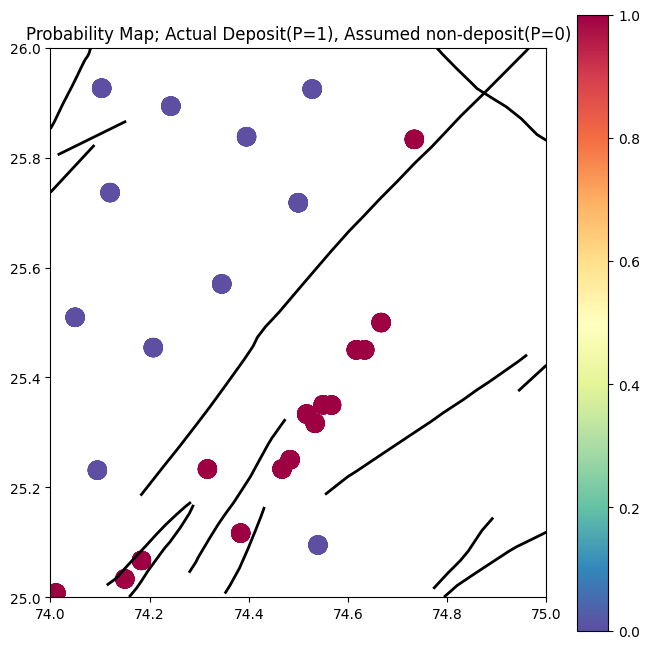

In [7]:
# Plot the probability of mineralization as well as the faults for visual inspection
f, ax = plt.subplots(figsize=(8,8))
fault_shp.to_crs(df.crs).plot(ax=ax, linestyle='-', linewidth=2, color='black')
df.plot(ax=ax, column="Probability_Mineralization", legend=True, cmap='Spectral_r', )
plt.title('Probability Map; Actual Deposit(P=1), Assumed non-deposit(P=0)')
plt.xlim([74, 75])
plt.ylim([25, 26])
plt.show()

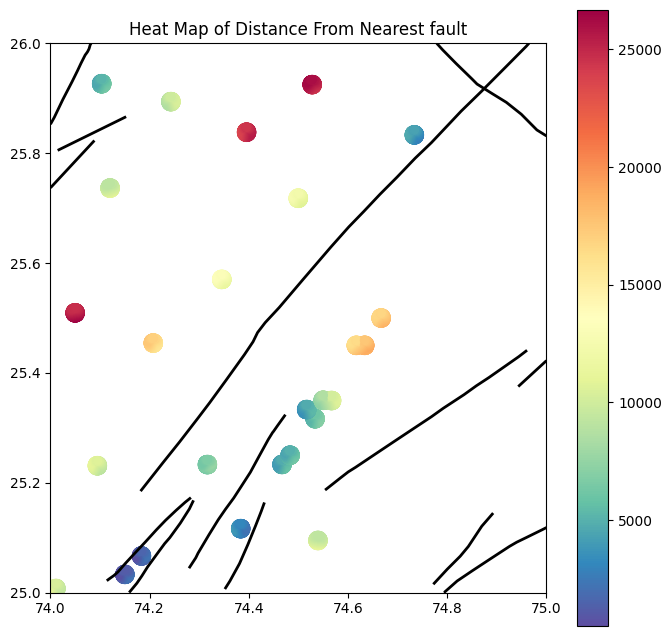

In [8]:
# Plot the probability of mineralization as well as the faults for visual inspection
f, ax = plt.subplots(figsize=(8,8))
fault_shp.to_crs(df.crs).plot(ax=ax, linestyle='-', linewidth=2, color='black')
df.plot(ax=ax, column="Dist_from_fault", legend=True, cmap='Spectral_r', )
plt.title('Heat Map of Distance From Nearest fault')
plt.xlim([74, 75])
plt.ylim([25, 26])
plt.show()

# Machine Learning Starts(KNN Regression)

In [9]:
# Dividing the dataframe into training and test dataframes. All points on eastern side of Longitude=74.54 are hidden
long_c=74.61
lat=25.5
UTM_Xc,UTM_Y=myProj(long_c,lat)
df_tr=df[df.UTM_X<=UTM_Xc]
df_ts=df[df.UTM_X>UTM_Xc]

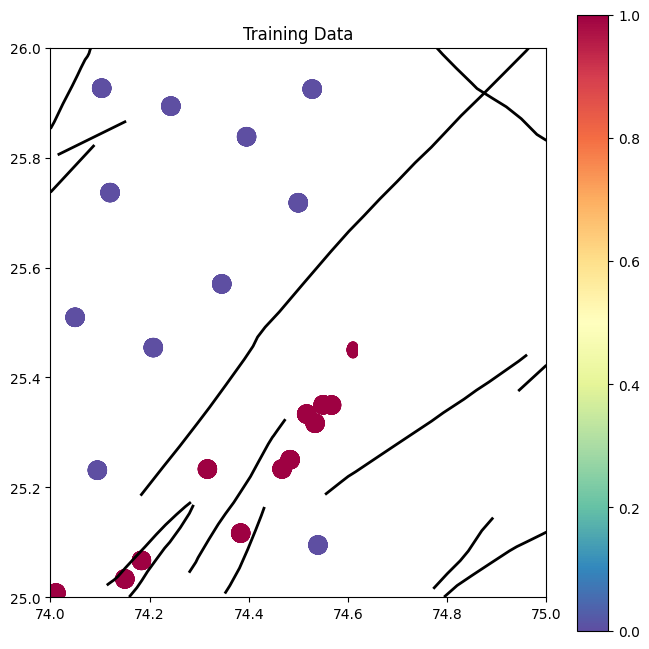

In [10]:
# Visualize the Training points
f, ax = plt.subplots(figsize=(8,8))
fault_shp.to_crs(df_tr.crs).plot(ax=ax, linestyle='-', linewidth=2, color='black')
df_tr.plot(ax=ax, column="Probability_Mineralization", legend=True, cmap='Spectral_r', )
plt.title('Training Data')
plt.xlim([74, 75])
plt.ylim([25, 26])
plt.show()

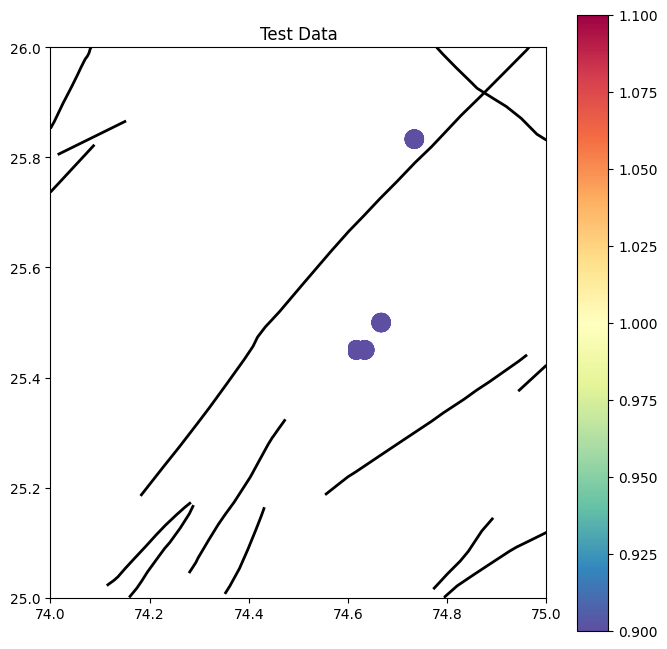

In [11]:
# Visualize the test points
f, ax = plt.subplots(figsize=(8,8))
fault_shp.to_crs(df_ts.crs).plot(ax=ax, linestyle='-', linewidth=2, color='black')
df_ts.plot(ax=ax, column="Probability_Mineralization", legend=True, cmap='Spectral_r', )
plt.title('Test Data')
plt.xlim([74, 75])
plt.ylim([25, 26])
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler       # Different data are in different range. We rescale all data in range [0,1]

X_tr = df_tr.iloc[:,2].values
X_tr=X_tr.reshape(-1,1)
np.shape(X_tr)
X_tr = MinMaxScaler().fit_transform(X_tr)
y_tr = df_tr.iloc[:,3].values

X_ts = df_ts.iloc[:,2].values
X_ts=X_ts.reshape(-1,1)
np.shape(X_ts)
X_ts = MinMaxScaler().fit_transform(X_ts)
y_ts = df_ts.iloc[:,3].values

In [13]:
from sklearn.neighbors import KNeighborsRegressor
model=KNeighborsRegressor(n_neighbors=15)    # Model Builder with K nearest neighbours
model.fit(X_tr, y_tr)                        # Model is fit(trained) on the training data
y_pred = model.predict(X_ts)                 # Model predict probability(y_pred) from test data(X_ts)

(array([3524.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1257.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

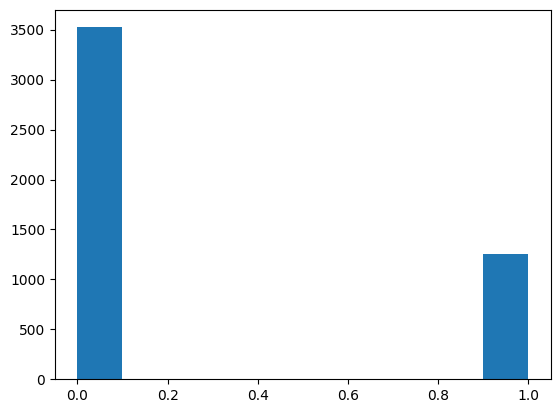

In [14]:
plt.hist(y_pred)

In [15]:
# Predict probability for all locations(training as well as test points)
X=df.iloc[:,2].values
X=X.reshape(-1,1)
X = MinMaxScaler().fit_transform(X)
all_pred = model.predict(X) 

In [16]:
df['Predicted_Probability']=all_pred          # Add a new column for all probabilites to the original dataframe
df

,UTM_X,UTM_Y,Dist_from_fault,Probability_Mineralization,geometry,Predicted_Probability
0,399300,2765350,11493.289357,1,POINT (74.00211 25.00029),0.266667
1,399350,2765350,11444.307490,1,POINT (74.00260 25.00029),0.333333
2,399400,2765350,11395.334467,1,POINT (74.00310 25.00029),0.333333
3,399450,2765350,11346.370402,1,POINT (74.00359 25.00030),0.333333
4,399500,2765350,11297.415412,1,POINT (74.00409 25.00030),0.400000
...,...,...,...,...,...,...
32549,449950,2845500,12117.647801,0,POINT (74.50104 25.72658),0.000000
32550,450000,2845500,12076.174189,0,POINT (74.50154 25.72659),0.000000
32551,450050,2845500,12034.765384,0,POINT (74.50204 25.72659),0.000000
32552,450100,2845500,11993.422058,0,POINT (74.50254 25.72659),0.000000


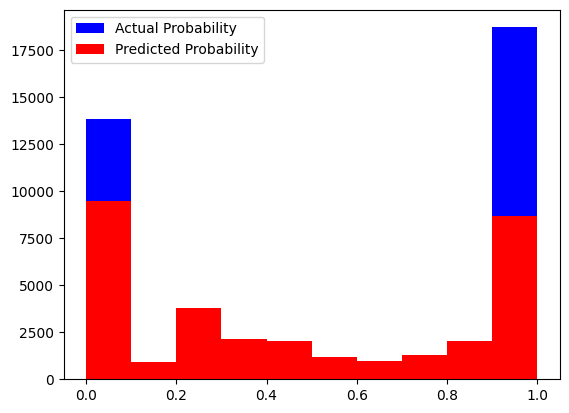

In [17]:
plt.hist(df.Probability_Mineralization, color='Blue', label='Actual Probability'), plt.hist(df.Predicted_Probability,color='Red', label='Predicted Probability')
plt.legend()

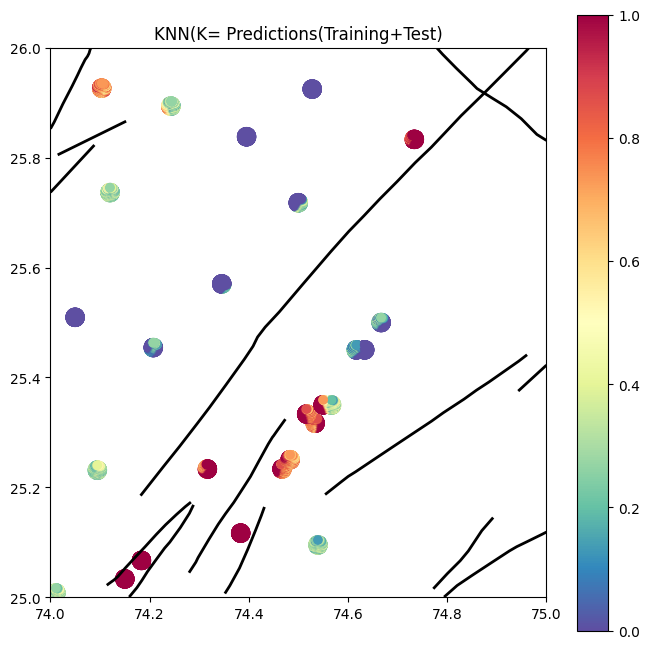

In [18]:
f, ax = plt.subplots(figsize=(8,8))
fault_shp.to_crs(df.crs).plot(ax=ax, linestyle='-', linewidth=2, color='black')
df.plot(ax=ax, column="Predicted_Probability", legend=True, cmap='Spectral_r', )
plt.title('KNN(K= Predictions(Training+Test)')
plt.xlim([74, 75])
plt.ylim([25, 26])
plt.savefig('45K_K15NN_MinPros.jpg', dpi=200)

# KNN Regression ends here. Random Forest(RF) Regression starts here.

In [19]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 50)  
model.fit(X_tr, y_tr)                  # The model learns the geophysics-Lithology relation from training data (Fitting)
y_pred = model.predict(X_ts)  
all_pred = model.predict(X) 
df['Predicted_Probability']=all_pred

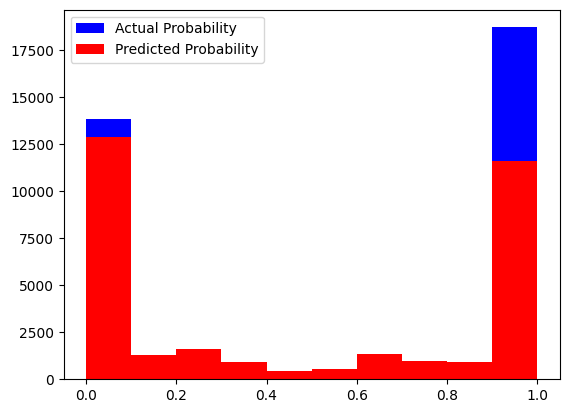

In [20]:
plt.hist(df.Probability_Mineralization, color='Blue', label='Actual Probability'), plt.hist(df.Predicted_Probability,color='Red', label='Predicted Probability')
plt.legend()

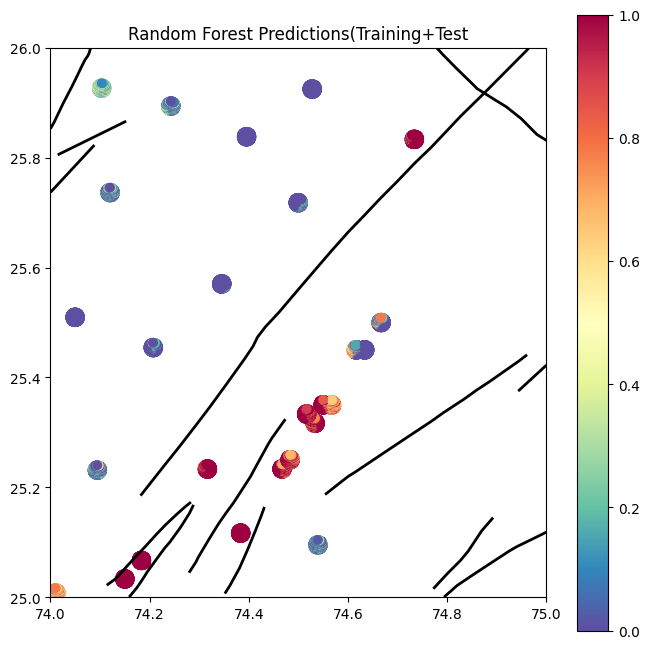

In [21]:
f, ax = plt.subplots(figsize=(8,8))
fault_shp.to_crs(df.crs).plot(ax=ax, linestyle='-', linewidth=2, color='black')
df.plot(ax=ax, column="Predicted_Probability", legend=True, cmap='Spectral_r', )
plt.title('Random Forest Predictions(Training+Test)')
plt.xlim([74, 75])
plt.ylim([25, 26])
plt.savefig('45K_RF50_MinPros.jpg', dpi=200)